# Intensivão de bibliotecas para Data Science

## Sugestão de stack básica Python de Data Science
* numpy (https://numpy.org/)
* scipy (https://www.scipy.org/)
* matplotlib (https://matplotlib.org/)
* seaborn (https://seaborn.pydata.org/index.html)
* plotly (https://plotly.com/python/)
* pandas (https://pandas.pydata.org/)
* sklearn (https://scikit-learn.org/stable/)
* tensorflow (https://www.tensorflow.org/?hl=pt-br)
* keras (https://keras.io/)
* NLTK (https://www.nltk.org/)
* Spacy (https://spacy.io/)

#### Seção especial para Computeção Evolucionária e Inteligência de Enxames
* DEAP (https://deap.readthedocs.io/en/master/examples/index.html)
* pymoo (https://pymoo.org/)
* pyswarms (https://pyswarms.readthedocs.io/en/latest/)



* Dica 1: Instale a versão gratuita do ambiente Anaconda e você terá essa stack e muito mais (talvez não tenha tensorflow e keras): https://www.anaconda.com/
* Dica 2: [Este](https://www.amazon.com.br/Introdu%C3%A7%C3%A3o-Minera%C3%A7%C3%A3o-Dados-Leandro-Augusto/dp/853528446X/ref=pd_lpo_14_img_0/133-2163411-4072220?_encoding=UTF8&pd_rd_i=853528446X&pd_rd_r=fdf419c7-f0be-4f4b-b1fa-16898fb89933&pd_rd_w=HArXu&pd_rd_wg=GXI6k&pf_rd_p=e7e26e7d-6256-4aae-92f9-7ffa337ed626&pf_rd_r=7SJ8ZYH9AR3EPZZKK4R7&psc=1&refRID=7SJ8ZYH9AR3EPZZKK4R7) livro é enxuto e possui todos os conhecimentos básicos necessários para se construir um pipeline completo de machine learning.

## Exemplo de classificação com sklearn

In [17]:
import array
import random
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import plotly.express as px
from sklearn import datasets
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pymoo.interface import sample
from pymoo.optimize import minimize
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from pymoo.factory import get_sampling
from pymoo.model.callback import Callback
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.algorithms.so_pso import PSO, PSOAnimation
from imblearn.under_sampling import RandomUnderSampler
from pymoo.factory import get_problem, get_visualization
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

Lendo a base de dados em CSV.

In [2]:
data = pd.read_csv('titanic/train.csv')

In [3]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen Carrie",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Antes de qualquer coisa, precisamos separar as bases de treino e teste para evitar qualquer information leakage.

In [4]:
independent_variables = set(data.columns) - set(['Survived'])
dependent_variable = 'Survived'

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[independent_variables],
                                                    data[dependent_variable],
                                                    test_size=0.33)

Verificando a razão entre dados com e sem valor.

In [6]:
for column in X_train.columns:
    print(column, pd.isnull(X_train[column]).sum() / X_train.shape[0])

Sex 0.0
Name 0.0
PassengerId 0.0
Fare 0.0
Age 0.1929530201342282
SibSp 0.0
Cabin 0.761744966442953
Ticket 0.0
Embarked 0.003355704697986577
Pclass 0.0
Parch 0.0


Cabin possui uma quantidade enorme de valores nulos. Qualquer tentativa de preenchimento dos mesmos resultará em uma grande quantidade de lixo sendo inserido na base. Portanto, a coluna será descartada. A coluna Age possui uma quantidade razoável de valores nulos. Penso ser difícil a inferência da idade a partir de outras colunas como método de preenchimento de valores nulos. Portanto, iremos manter do jeito que está, mas precisaremos de um método que funcione com valores nulos.

Algumas colunas não possuem informação útil para determinar a probabilidade de sobrevivência do passageiro: PassengerId, Ticket e Name. Porém, sabe-se que algumas famílias puderam se salvar inteiramente por serem ricas, ou "mais importantes do que outras". Portanto extrairemos o sobrenome de cada passageira e usaremos como uma coluna categórica no lugar de Name. Abaixo você pode ver o efeito desta transformação e, em seguida, atribuímos a coluna resultante à coluna Name, visto que não vamos mais usá-la.

In [7]:
X_train['Name'].apply(lambda x: x.split(',')[0])

545       Nicholson
14          Vestrom
73     Chronopoulos
187         Romaine
58             West
           ...     
287       Naidenoff
528         Salonen
156         Gilnagh
66              Nye
665         Hickman
Name: Name, Length: 596, dtype: object

In [8]:
X_train['Name'] = X_train['Name'].apply(lambda x: x.split(',')[0])
X_test['Name'] = X_test['Name'].apply(lambda x: x.split(',')[0])

Precisamos separar as colunas categóricas das colunas numéricas para darmos tratamentos diferentes para as mesmas.

In [9]:
categorical_columns = ['Sex', 'Embarked', 'Name']
numerical_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'

Precisamos transformar os valores categóricos em valores numéricos para que os classificadores de algumas bibliotecas possam funcionar corretamente. Poderíamos usar a classe sklearn.preprocessing.LabelEncoder da biblioteca scikit-learn. Porém, esta classe não suporta valores desconhecidos. Ou seja, se você treina o seu modelo com uma determinada base dados em que as colunas categóricas possuem determinados valores mas ao colocar o seu modelo em produção (ou até ao apresentar a base de teste) o seu modelo se depara com valores novos para essas colunas, a classe levantará um erro. Poderíamos também implementar manualmente a conversão, mas quando tudo é feito no nível da linguagem Python, o processo pode ficar muito lento. Portanto, vamos tentar ao máximo usar o que já existe implementado.

A classe OneHotEncoder implementa o one-hot encoding que é normalmente necessário em métodos que lidam estritamente com dados numéricos (e.g. redes neurais, svm, etc). Para entender melhor, visitem [este](https://medium.com/@arthurlambletvaz/one-hot-encoding-o-que-%C3%A9-cd2e8d302ae0) link. Porém, não iremos usar estes algoritmos pois decidimos manter os valores nulos da coluna Age. Iremos usar as implementações de florestas de árvores de decisão da biblioteca [LightGBM](https://lightgbm.readthedocs.io/en/latest/), que suporta valores nulos criando uma branch em cada nó para os casos em que a coluna correspondente apresenta valores nulos. Para árvores de decisão, não precisamos usar o método one-hot encoding, pois as decisões nos nós podem ser definidas considerando grupos de valores categóricos para cada uma das branches. A grande vantagem de não haver a necessidade de usar o método one-hot encoding é o fato de que o método gera uma quantidade muito grande de dimensões no espaço de decisão quando as colunas categóricas possuem muitos valores distintos, o que dificulta muito o processo de aprendizagem. Portanto, usaremos a classe OneHotEncoder apenas para gerar as representações unárias e, em seguida, pegar os índices de cada valor 1. Como já está tudo implementado, o tempo computacional para sua execução deverá ser menor.

Antes de "encodar", precisamos preencher os valores nulos de cada coluna categórica com um valor diferente dos que já existem, pois a classe OneHotEncoder não suporta valores nulos. O encoder vai atribuir um valor único para esses valores nulos assim como faz para as outras colunas. Este valor deve ser descoberto para que o mesmo sirva de referência para, após a conversão final para valores numéricos inteiros, voltar para o valor nulo, pois decidimos mantê-lo.

Observação: para fazer o OneHotEncoder funcionar desta forma, precisei instalar a versão [0.23.2](https://pypi.org/project/scikit-learn/) (a mais recente até o momento) da lib.

In [10]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

In [11]:
for column in categorical_columns:
    categorical_columns_X_train = X_train[column].fillna('None')
    categorical_columns_X_test = X_test[column].fillna('None')
    onehot_encoder.fit(categorical_columns_X_train.values.reshape(-1,1))
    categorical_columns_X_train = onehot_encoder.fit_transform(categorical_columns_X_train.values.reshape(-1,1))
    categorical_columns_X_test = onehot_encoder.transform(categorical_columns_X_test.values.reshape(-1,1))
    encoded_column_train = pd.DataFrame(categorical_columns_X_train.todense()).idxmax(axis=1)
    encoded_column_test = pd.DataFrame(categorical_columns_X_test.todense()).idxmax(axis=1)
    temp_df_train = pd.DataFrame({0: X_train[column].values, 1: encoded_column_train.values})
    encoded_column_train = temp_df_train.apply(lambda x: None if pd.isnull(x[0]) else int(x[1]), axis=1)
    temp_df_test = pd.DataFrame({0: X_test[column].values, 1: encoded_column_test.values})
    encoded_column_test = temp_df_test.apply(lambda x: None if pd.isnull(x[0]) else int(x[1]), axis=1)
    X_train[column] = encoded_column_train
    X_test[column] = encoded_column_test

In [12]:
X_train

,Sex,Name,PassengerId,Fare,Age,SibSp,Cabin,Ticket,Embarked,Pclass,Parch
545,1.0,95.0,546,26.0000,64.0,0,NaN,693,3.0,1,0
14,1.0,23.0,15,7.8542,14.0,0,NaN,350406,3.0,3,0
73,1.0,371.0,74,14.4542,26.0,1,NaN,2680,3.0,3,0
187,1.0,232.0,188,26.5500,45.0,0,NaN,111428,3.0,1,0
58,0.0,10.0,59,27.7500,5.0,1,NaN,C.A. 34651,3.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...
287,0.0,47.0,288,7.8958,22.0,0,NaN,349206,2.0,3,0
528,0.0,8.0,529,7.9250,39.0,0,NaN,3101296,3.0,3,0
156,1.0,311.0,157,7.7333,16.0,0,NaN,35851,0.0,3,0
66,1.0,380.0,67,10.5000,29.0,0,F33,C.A. 29395,3.0,2,0


Estas são as colunas selecionadas:

In [13]:
X_train[categorical_columns + numerical_columns]

,Sex,Embarked,Name,Pclass,Age,SibSp,Parch,Fare
545,1.0,3.0,95.0,1,64.0,0,0,26.0000
14,1.0,3.0,23.0,3,14.0,0,0,7.8542
73,1.0,3.0,371.0,3,26.0,1,0,14.4542
187,1.0,3.0,232.0,1,45.0,0,0,26.5500
58,0.0,3.0,10.0,2,5.0,1,2,27.7500
...,...,...,...,...,...,...,...,...
287,0.0,2.0,47.0,3,22.0,0,0,7.8958
528,0.0,3.0,8.0,3,39.0,0,0,7.9250
156,1.0,0.0,311.0,3,16.0,0,0,7.7333
66,1.0,3.0,380.0,2,29.0,0,0,10.5000


Antes de finalmente treinarmos nosso modelo, precisamos verificar se a distribuição de classes está balanceada.

In [14]:
y_train.value_counts()

0    356
1    240
Name: Survived, dtype: int64

Vemos que existe um certo desbalanceamento. Portanto, precisamos usar algum método de balanceamento de bases. Existem três opções: undersampling, oversampling e um meio termo. Nos métodos de undersampling, a classe majoritária é reduzida até ser igualada à classe minoritária. Esta é a opção mais segura, pois não cria dados artificiais nem replica dados. Porém, reduz-se o tamanho da amostra. No nosso caso, a amostra já não é muito grande, então pode não ser a melhor escolha. A opção de oversampling, por sua vez, aumenta a classe minoritária para se igualar à majoritária. Não tem o problema de reduzir demais o tamanho da amostra, mas pode gerar dados ruidosos ou duplicação de dados, o que enviesa o processo de treinamento dando mais peso aos registros duplicados. Uma boa opção é o meio termo, como o método SMOTE, que cria alguns dados e remove outros. Porém, para a criação de novos dados, o SMOTE espera que os dados sejam todos numéricos, o que não é o nosso caso. Então, nesse caso, a opção mais interessante seria o undersampling, visto que particularmente não conheço outros métodos (certamente existe algum que funcione para dados categóricos). Você pode encontrar VÁRIOS métodos (aqui)[https://imbalanced-learn.readthedocs.io/en/stable/api.html].

In [15]:
dataset_balancing = RandomUnderSampler()
resampled_X_train, resampled_y_train = dataset_balancing.fit_resample(X_train, y_train)

In [16]:
resampled_y_train.value_counts()

1    240
0    240
Name: Survived, dtype: int64

Convertendo as variáveis numéricas para float e as categóricas para category:

In [17]:
for var in numerical_columns:
    resampled_X_train[var] = resampled_X_train[var].astype(float)
    X_test[var] = X_test[var].astype(float)
for var in categorical_columns:
    resampled_X_train[var] = resampled_X_train[var].astype('category')
    X_test[var] = X_test[var].astype('category')

Agora podemos começar a trabalhar na modelagem. A lib LightGBM possui uma série de hiperparâmetros para serem ajustados. Podemos então fixar alguns menos importantes e testarmos algumas combinações de valores distintos dos parâmetros mais importantes. Para isso, usaremos um método de tuning muito simples mas bastante usado: Grid Search. Utilizaremos a base de treino para, através do método Grid Search com K-Fold Cross Validation, encontrar um bom ajuste paramétrico e um bom modelo. Vamos utilizar o f1 score como função objetivo, pois representa bem simultaneamente a precision e a recall dos resultados de classificação (se um dos dois objetivos estiverem baixos, o valor da f1 score será baixo).

In [18]:
best_model = None
best_score = 0
gbm = lgb.LGBMClassifier(
            categorical_features=categorical_columns,
            objective='binary')
param_grid = {
    'num_leaves': [64, 128, 256],
    'learning_rate': [1e-6, 1e-4, 1e-2],
    'max_depth': [6, 7, 8],
    'n_estimators': [10, 20, 30, 50, 100, 200, 300, 500, 750, 1000]}
gsearch = GridSearchCV(estimator=gbm, 
                       param_grid=param_grid, 
                       cv=5)
lgb_model = gsearch.fit(X=resampled_X_train[categorical_columns + numerical_columns],
                        y=resampled_y_train, eval_metric='f1_score')

In [19]:
lgb_model.best_score_

0.6666666666666667

In [20]:
lgb_model.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'num_leaves': 64}

Após o treinamento, vamos pegar o melhor modelo (best estimator) e aplicar a base de teste para avaliar a qualidade do modelo em dados nunca vistos antes.

In [21]:
prediction_test = lgb_model.best_estimator_.predict(X_test[categorical_columns + numerical_columns])

In [22]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       193
           1       0.59      0.63      0.61       102

    accuracy                           0.72       295
   macro avg       0.69      0.70      0.69       295
weighted avg       0.72      0.72      0.72       295



Nós podemos ver um ranking de importância das features!

[]

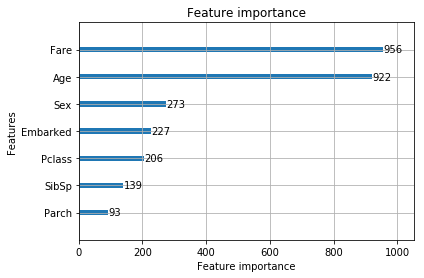

In [23]:
lgb.plot_importance(lgb_model.best_estimator_)
plt.plot()

## Exemplo de classificação com Tensorflow

Vamos primeiro resetar as bases de treino e teste.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data[independent_variables],
                                                    data[dependent_variable],
                                                    test_size=0.33)

In [71]:
X_train['Name'] = X_train['Name'].apply(lambda x: x.split(',')[0])
X_test['Name'] = X_test['Name'].apply(lambda x: x.split(',')[0])

Como vamos usar redes neurais, precisamos usar o one-hot encoding tanto na entrada como na saída.

In [72]:
categorical_columns_X_train = X_train[categorical_columns].fillna('None')
categorical_columns_X_test = X_test[categorical_columns].fillna('None')

In [73]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_columns_X_train = onehot_encoder.fit_transform(categorical_columns_X_train)
categorical_columns_X_test = onehot_encoder.transform(categorical_columns_X_test)

In [74]:
y_train = onehot_encoder.fit_transform(y_train.values.reshape(-1,1))
y_test = onehot_encoder.transform(y_test.values.reshape(-1,1))

Precisamos deletar as colunas categóricas antigas e concatenar as novas colunas transformadas com one-hot encoding linha a linha.

In [75]:
for column in categorical_columns:
    del X_train[column]
    del X_test[column]

In [76]:
X_train = np.concatenate([X_train[numerical_columns].values, categorical_columns_X_train.todense()], axis=1)
X_test = np.concatenate([X_test[numerical_columns].values, categorical_columns_X_test.todense()], axis=1)

Precisamos preencher os valores nulos da coluna de idade (coluna 1). Para esse caso, usaremos a média dos outros valores não-nulos, mesmo não sendo o ideal. Outras alternativas podem ser estudadas [aqui](https://measuringu.com/handle-missing-data/#:~:text=Use%20caution%20unless%20you%20have,value%20from%20the%20other%20values.)

In [77]:
for column in range(X_train.shape[0]):
    X_train_t = X_train.transpose()
    print(column, pd.isnull(X_train_t[column]).sum() / X_train.shape[0])

0 0.0
1 0.19966442953020133
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.

IndexError: index 482 is out of bounds for axis 0 with size 482

In [78]:
column_1 = X_train.transpose()[1]
column_1_mean = column_1[pd.isnull(column_1)[0] == False].mean()

In [79]:
X_train_t = X_train.transpose()
X_train_t[1][pd.isnull(X_train_t[1])[0]] = column_1_mean
X_train = X_train_t.transpose()

In [80]:
X_test_t = X_test.transpose()
X_test_t[1][pd.isnull(X_test_t[1])[0]] = column_1_mean
X_test = X_test_t.transpose()

Para evitar um desequilíbrio na importância das colunas e uma deterioração do processo de aprendizagem, precisamos normalizar as variáveis numéricas entre 0 e 1.

In [81]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

Vamos montar um MLP com 2 camadas escondidas com o dobre de neurônios da camada de entrada, todas com função de ativação relu e algoritmo de otimização Adam.

In [82]:
inputs = keras.Input(shape=(X_train.shape[1],))
dense_1 = layers.Dense(X_train.shape[1] * 2, activation="relu")(inputs)
dense_2 = layers.Dense(X_train.shape[1] * 2, activation="relu")(dense_1)
output = layers.Dense(2, activation="sigmoid")(dense_2)
model = keras.Model(inputs=inputs, outputs=output, name="titanic_model")

In [83]:
model.summary()

Model: "titanic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 482)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 964)               465612    
_________________________________________________________________
dense_13 (Dense)             (None, 964)               930260    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 1930      
Total params: 1,397,802
Trainable params: 1,397,802
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Train on 476 samples, validate on 120 samples
Epoch 1/20
476/476 [==============================] - 0s 713us/sample - loss: 0.0379 - acc: 0.9916 - val_loss: 0.6972 - val_acc: 0.7917
Epoch 2/20
476/476 [==============================] - 0s 312us/sample - loss: 0.0177 - acc: 0.9937 - val_loss: 0.6161 - val_acc: 0.8042
Epoch 3/20
476/476 [==============================] - 0s 340us/sample - loss: 0.0133 - acc: 0.9958 - val_loss: 0.6957 - val_acc: 0.7625
Epoch 4/20
476/476 [==============================] - 0s 379us/sample - loss: 0.0123 - acc: 0.9958 - val_loss: 0.7142 - val_acc: 0.7708
Epoch 5/20
476/476 [==============================] - 0s 333us/sample - loss: 0.0201 - acc: 0.9916 - val_loss: 0.8978 - val_acc: 0.7167
Epoch 6/20
476/476 [==============================] - 0s 347us/sample - loss: 0.0147 - acc: 0.9937 - val_loss: 0.7011 - val_acc: 0.7833
Epoch 7/20
476/476 [==============================] - 0s 373us/sample - loss: 0.0267 - acc: 0.9895 - val_loss: 0.7899 - val_acc: 0.7417
Ep

In [91]:
prediction = model.predict(X_test).argmax(axis=1)

In [107]:
print(classification_report(y_test.todense().argmax(axis=1), prediction))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       176
           1       0.80      0.66      0.72       119

    accuracy                           0.80       295
   macro avg       0.80      0.78      0.78       295
weighted avg       0.80      0.80      0.79       295



## Exemplo de clusterização com K-means e Clustermap (clusterização hierárquica)

Para experimentarmos um pouco de clusterização, usaremos a tradicional base da iris, onde flores devem ser classificadas de acordo com suas características.

In [111]:
iris = datasets.load_iris()

In [116]:
data = iris['data']

In [141]:
data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

A base possui 3 tipos de flores. Então, queremos encontrar 3 clusteres.

In [122]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

KMeans(n_clusters=3)

Para visualizar em um plano 2D, usaremos PCA para reduzir dimensionalidade, projetando os vetores antes em um espaço com 4 dimensões para um espaço de 2 dimensões.

In [130]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(data)

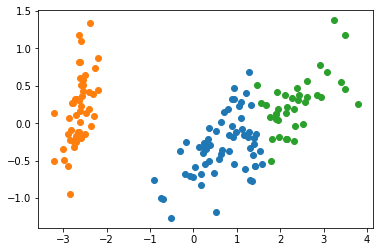

In [140]:
for i in range(3):
    selected_data = transformed_data[kmeans.labels_ == i].transpose()
    plt.plot(selected_data[0], selected_data[1], 'o')
plt.show()

In [148]:
target_ = pd.Series(kmeans.labels_)

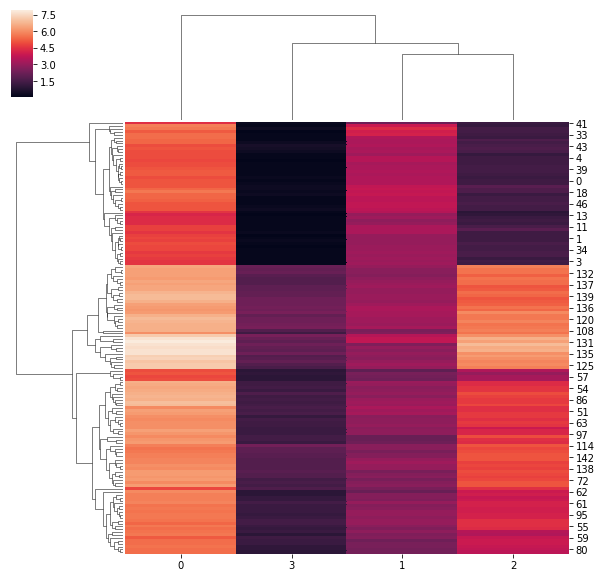

In [144]:
g = sns.clustermap(data)

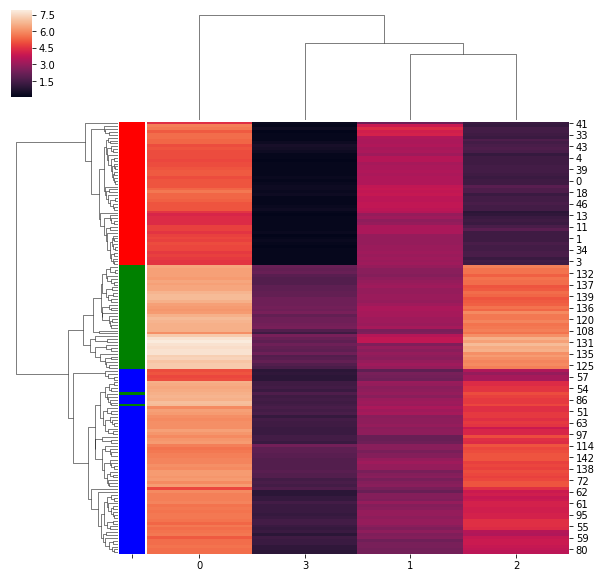

In [151]:
lut = dict(zip(target_.unique(), "rbg"))
row_colors = target_.map(lut)
g = sns.clustermap(pd.DataFrame(data), row_colors=row_colors)

## Exemplo de otimização usando pymoo para computação evolucionária e inteligência de enxames

Vamos começar definindo qual função iremos otimizar (i.e. qual problema de otimização iremos resolver): Ackley. Ackley é uma função artificial utilizada para benchmarks de metaheurísticas. Abaixo podemos visualizar a sua superfície.

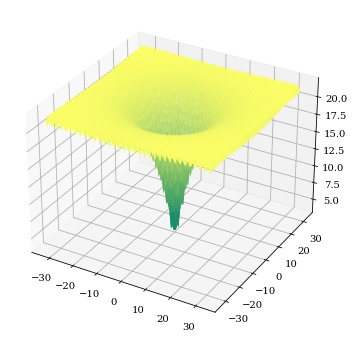

In [2]:
problem = get_problem("ackley", n_var=2, a=20, b=1/5, c=2 * np.pi)
get_visualization("fitness-landscape", problem, angle=(45, 45), _type="surface").show()

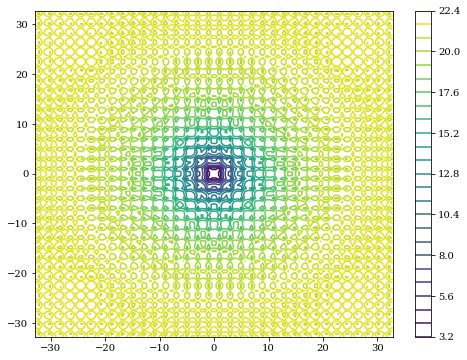

In [3]:
get_visualization("fitness-landscape", problem, _type="contour", colorbar=True).show()

Em seguido nós podemos rapidamente instanciar um algoritmo genético e executá-lo na função Ackley.

In [4]:
sampling = get_sampling('real_lhs')
X = sample(sampling, 100, 2) * 60 - 30

In [5]:
algorithm = GA(pop_size=100, eliminate_duplicates=True, sampling=X)
res = minimize(problem,
               algorithm,
               seed=1,
               verbose=False)
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = [ 5.01169429e-07 -2.28878902e-06]
F = [6.62719741e-06]


Segue abaixo a solução da função Ackley pelo algoritmo PSO.

In [14]:
sampling = get_sampling('real_lhs')
X = sample(sampling, 100, 2) * 60 - 30

In [37]:
class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.current_iteration = 0
        self.iterations = []
        self.fitnesses = []
        self.posX = []
        self.posY = []

    def notify(self, algorithm):
        self.iterations += [self.current_iteration] * algorithm.pop.get("F").shape[0]
        self.current_iteration += 1
        self.fitnesses += algorithm.pop.get("F").transpose().tolist()[0]
        pos = algorithm.pop.get("X").transpose()
        self.posX += pos[0].tolist()
        self.posY += pos[1].tolist()

In [38]:
algorithm = PSO(max_velocity_rate=0.025, sampling=X)
res = minimize(problem,
               algorithm,
               callback=MyCallback(),
               save_history=True,
               verbose=False)
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

Best solution found: 
X = [-2.46578333e-08 -7.61726497e-09]
F = [7.29948941e-08]


Podemos também visualizar uma animação da evolução do algoritmo com o passar do tempo. Os dados para visualização foram coletados pelo callback MyCallback.

In [39]:
pso_data = pd.DataFrame({'iterations': res.algorithm.callback.iterations,
                         'fitnesses': res.algorithm.callback.fitnesses,
                         'posX': res.algorithm.callback.posX,
                         'posY': res.algorithm.callback.posY})

In [40]:
pso_data

,iterations,fitnesses,posX,posY
0,0,5.818979e+00,-2.967873e-01,-1.404097e+00
1,0,1.043865e+01,3.108264e+00,2.492820e+00
2,0,1.076224e+01,-3.678895e+00,1.430999e+00
3,0,1.267112e+01,-4.244415e+00,-4.139917e+00
4,0,1.567648e+01,-8.125617e+00,2.373988e+00
...,...,...,...,...
1675,69,7.320355e-05,-5.894863e-07,-2.586834e-05
1676,69,1.320588e-03,3.023977e-05,-4.638791e-04
1677,69,1.753497e-04,1.096270e-05,6.098178e-05
1678,69,3.628904e-07,1.275788e-07,-1.359394e-08


In [42]:
px.scatter(pso_data, x="posX", y="posY", animation_frame="iterations", color="fitnesses",
           hover_name="fitnesses", range_x=[-30,30], range_y=[-30,30], width=800, height=800)